In [164]:
# we are building a character level decoder-only language model 
# original paper Transformer is a encoder-decoder language model for machine translation. 
# best explanation of attention in tranformer: https://jalammar.github.io/illustrated-transformer/
# encoder-decoder: unmasked attention to both past and future inside encoder; decoder takes K, V from the final output of encoder
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>
# v.
# decoder-only: attention only to the past 

In [165]:
import torch
import torch.nn.functional as F
import torch.nn as nn

In [166]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [167]:
# vocab = set(list(text))
vocab = sorted(list(set(text)))
vocab_size = len(vocab)
print(vocab)
print(vocab_size)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
65


In [168]:
# create mapping from char to integers
stoi = {s:i for i, s in enumerate(vocab)}
itos = {i:s for s, i, in stoi.items()}
print(stoi)
print(itos)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
{0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: 'g', 46: 'h', 47: 'i',

In [169]:
# define 2 lambda functions
# encode: turn a string to a list of integers
encode = lambda s: [stoi[c] for c in s]
# decode: turn a list of integer to string
decode = lambda ixs: "".join([itos[ix] for ix in ixs])
print(encode("yuxiao"))
print(decode(encode("yuxiao")))

# commonly used word level tokenizer that break word into sub-words are SentencePiece, tiktoken, both used BPE ("byte-pair-encoding")

[63, 59, 62, 47, 39, 53]
yuxiao


In [170]:
import tiktoken
gpt2_encoder = tiktoken.get_encoding("gpt2")
print(gpt2_encoder.n_vocab)
print(gpt2_encoder.encode("yuxiao"))

50257
[88, 2821, 13481]


In [171]:
# let's encode the whole document into list, then to torch tensors
print(encode(text)[:100])
# data = torch.tensor(encode(text))  #torch.int64
data = torch.tensor(encode(text), dtype=torch.long)  
print(data.shape, data.dtype)

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43, 1, 54, 56, 53, 41, 43, 43, 42, 1, 39, 52, 63, 1, 44, 59, 56, 58, 46, 43, 56, 6, 1, 46, 43, 39, 56, 1, 51, 43, 1, 57, 54, 43, 39, 49, 8, 0, 0, 13, 50, 50, 10, 0, 31, 54, 43, 39, 49, 6, 1, 57, 54, 43, 39, 49, 8, 0, 0, 18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 37, 53, 59]
torch.Size([1115394]) torch.int64


In [172]:
# split data into train and validation
n = int(len(data) * 0.9)
print(n)
train_data = data[:n]
val_data = data[n:]
print("train data: ", len(train_data))
print("val data:v ", len(val_data))

1003854
train data:  1003854
val data:v  111540


In [173]:
# let's consider the time dimension to build x and y

# we will build x from len of 1 all the way to len of 7, various length help us do better ar reference, when given input as short as 1 char, 
# model knows how to predict next because it's seen it in the training data

block_size = 8   # the longest context window  # for every block_size in the data, we'll build 7 examples

block_x = data[:block_size]  # the first 7 chars
block_y = data[1:block_size+1]  # shifted back by 1
print("block_x: ", block_x)
print("block_y: ", block_y)
for i in range(len(block_x)):
    input = block_x[:i+1]
    target = block_y[i]
    print(f"input: {input}, target = {target}")


block_x:  tensor([18, 47, 56, 57, 58,  1, 15, 47])
block_y:  tensor([47, 56, 57, 58,  1, 15, 47, 58])
input: tensor([18]), target = 47
input: tensor([18, 47]), target = 56
input: tensor([18, 47, 56]), target = 57
input: tensor([18, 47, 56, 57]), target = 58
input: tensor([18, 47, 56, 57, 58]), target = 1
input: tensor([18, 47, 56, 57, 58,  1]), target = 15
input: tensor([18, 47, 56, 57, 58,  1, 15]), target = 47
input: tensor([18, 47, 56, 57, 58,  1, 15, 47]), target = 58


In [174]:
batch_size = 4
block_size = 8
# randomly select 4 independent data examples of sequence of 8, may start from anywhere
# if data len of 10,  block_size = 8, sampel from position [0,1,2]
data = torch.tensor([9,8,7,1,2,3,4,5,6,0])
for _ in range(3):  # it takes 2.5 iterations of getting batch to cover the whole data
    ix = torch.randint(low=0, high = len(data) - block_size + 1, size=(batch_size,))  # high is exclusive, size=tuple define output shape
    print(ix)

tensor([1, 1, 2, 1])
tensor([2, 1, 1, 1])
tensor([2, 0, 0, 2])


In [285]:
# data loader: get batch of chunks ofdata 

torch.manual_seed(1337)
# same get batch for both train data and val data, return one batch of x and y
def get_batch(split):
    data = train_data[:20] if split == "train" else val_data
    # WRONG: ix = torch.randint(low=0, high = len(data) - block_size + 1, size=(batch_size,))
    ix = torch.randint(low=0, high = len(data) - block_size, size=(batch_size,))
    xb = torch.stack([data[startpos: startpos + block_size] for startpos in ix]) 
    # stack takes list of tensors and stack them veritically, along dim=0
    yb = torch.stack([data[startpos+1: startpos + block_size+1] for startpos in ix])

    return xb, yb
    
xb, yb = get_batch("train")
print(xb)
print(yb)

for b in range(batch_size):
    for t in range(block_size):
        input = xb[b, :t+1]
        target = yb[b, t]
        print(f"input = {input}, target = {target}")

tensor([[47, 58, 47, 64, 43, 52, 10,  0],
        [47, 56, 57, 58,  1, 15, 47, 58],
        [58, 47, 64, 43, 52, 10,  0, 14],
        [58,  1, 15, 47, 58, 47, 64, 43],
        [43, 52, 10,  0, 14, 43, 44, 53],
        [47, 56, 57, 58,  1, 15, 47, 58],
        [43, 52, 10,  0, 14, 43, 44, 53],
        [56, 57, 58,  1, 15, 47, 58, 47],
        [15, 47, 58, 47, 64, 43, 52, 10],
        [56, 57, 58,  1, 15, 47, 58, 47],
        [58, 47, 64, 43, 52, 10,  0, 14],
        [18, 47, 56, 57, 58,  1, 15, 47],
        [47, 64, 43, 52, 10,  0, 14, 43],
        [64, 43, 52, 10,  0, 14, 43, 44],
        [15, 47, 58, 47, 64, 43, 52, 10],
        [64, 43, 52, 10,  0, 14, 43, 44],
        [43, 52, 10,  0, 14, 43, 44, 53],
        [58,  1, 15, 47, 58, 47, 64, 43],
        [47, 64, 43, 52, 10,  0, 14, 43],
        [47, 58, 47, 64, 43, 52, 10,  0],
        [ 1, 15, 47, 58, 47, 64, 43, 52],
        [15, 47, 58, 47, 64, 43, 52, 10],
        [56, 57, 58,  1, 15, 47, 58, 47],
        [15, 47, 58, 47, 64, 43, 5

In [177]:
# first build the simplest NN language model
# input will be just one char, (the aboved input is not used here, but later in GPT when we apply attention)
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embed_dim = embed_dim
        # self.embeddings = torch.randn(vocab_size, vocab_size) # serve as the lookup table, turn a char into vector of embeds
        self.embedding_table = nn.Embedding(vocab_size, vocab_size)  # Embedding: variables from ~N(0,1)
                                      
    def forward(self, input, target):   # idx: this is a bigram setting, so input will be only one char, here pass its integer
        # input and target are shape of (B (batch_size) , T (block_size) )
        
        logits = self.embedding_table(input)
        print("logits shape: ", logits.shape)
        
        # wrong: loss = F.cross_entropy(logits, target)  
        # cross_entropy expect input has to be a Tensor of size (C) for unbatched input, (minibatch,C) or (minibatch, C, d1, ..dk) with K>=1
        # for the K-dimensional case. The last being useful for higher dimension inputs, such as computing cross entropy loss per-pixel for 2D images 
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        target = target.view(B*T)

        loss = F.cross_entropy(logits, target)  # comply with (minibatch,C)
        return logits, loss
 

In [93]:
bigram_model = BigramLanguageModel(vocab_size)
logits, loss = bigram_model(xb, yb)
print(logits.shape)
print(loss)
# expected loss
# prob = 1/65
# - ln(1/65) = 4.17

logits shape:  torch.Size([4, 8, 65])
torch.Size([32, 65])
tensor(4.3751, grad_fn=<NllLossBackward0>)


In [178]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embed_dim = embed_dim
        # self.embeddings = torch.randn(vocab_size, vocab_size) # serve as the lookup table, turn a char into vector of embeds
        self.embedding_table = nn.Embedding(vocab_size, vocab_size)  # Embedding: variables from ~N(0,1)
                                      
    def forward(self, input, target=None):  # make target optional
        
        logits = self.embedding_table(input) 
        B, T, C = logits.shape
        
        if target is None:  
            loss = None    # logits returned will be shape (B, T, C)
        else:
            logits = logits.view(B*T, C)
            target = target.view(B*T)
            loss = F.cross_entropy(logits, target)  # comply with (minibatch,C)
        return logits, loss

    # def generate(self, input, max_new_tokens):  # work for bigram
    #     out = []
    #     for i in range(max_new_tokens):
    #         # nn.Module  When you create an instance of this module and call it with input data, 
    #         # PyTorch internally calls the forward method, passing the input data to it.
    #         logits, _ = self(input)
    #         # print("logits shape: ", logits.shape)
    #         probs = F.softmax(logits, dim=-1)
    #         idx_next = torch.multinomial(probs, num_samples=1)
    #         # print("idx_next shape: ", idx_next.shape)
    #         out.append(idx_next.item())
    #         input = idx_next
    #     return out
    
    def generate(self, input, max_new_tokens):  # more general, allow to condition on more previous chars
    
        for i in range(max_new_tokens):
            # nn.Module  When you create an instance of this module and call it with input data, 
            # PyTorch internally calls the forward method, passing the input data to it.
            logits, _ = self(input)
            # print("logits shape: ", logits.shape)  # (B,T,C)
            logits = logits[:, -1, :]   # becomes (B, C)
            probs = F.softmax(logits, dim=-1)    # (B, C)
            # print("probs shape: ", probs.shape)
            idx_next = torch.multinomial(probs, num_samples=1)
            # print("idx_next shape: ", idx_next.shape)
            input = torch.cat((input, idx_next), dim=1)

        return input


In [179]:
bigram_model = BigramLanguageModel(vocab_size)
logits, loss = bigram_model(xb, yb)
print(logits.shape)
print(loss)

torch.Size([32, 65])
tensor(4.3875, grad_fn=<NllLossBackward0>)


In [180]:
input = torch.tensor([0]).view(1, 1)  # (B, T)  # 0 is decoded as "\n", okay as a starting token
print(input)
print(input.shape)
out = bigram_model.generate(input, 100)
print("out shape: ", out.shape)  # [1, 101])
print(decode(out[0].tolist()))   # this is random model (not trained)

tensor([[0]])
torch.Size([1, 1])
out shape:  torch.Size([1, 101])

lfJeukRuaRJKXAYtXzfJ:HEPiu--sDioi;ILCo3pHNTmDwJsfheKRxZCFs
lZJ XQc?:s:HEzEnXalEPklcPU cL'DpdLCafBheH


In [259]:
# now let's train the model

# device = 'cuda' if torch.cuda.is_available() else 'cpu'  # mac uses AMD gpu not cuda, 
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
# Starting with PyTorch 1.12, support for Apple's Metal Performance Shaders (MPS) backend has been introduced, which allows you to utilize the GPU on newer Macs with Apple Silicon (M1, M2, etc.)
print(device)

block_size = 8
batch_size = 32

def get_batch(split):
    data = train_data if split == "train" else val_data
    ix = torch.randint(low=0, high = len(data) - block_size, size=(batch_size,))
    xb = torch.stack([data[startpos: startpos + block_size] for startpos in ix]) 
    # stack takes list of tensors and stack them veritically, along dim=0
    yb = torch.stack([data[startpos+1: startpos + block_size+1] for startpos in ix])
    xb, yb = xb.to(device), yb.to(device)
    return xb, yb

mps


In [182]:
bigram_model = BigramLanguageModel(vocab_size)
model = bigram_model.to(device)

learning_rate = 1e-2   # default 0.001, for our simple model, can be bigger
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)

for step in range(10000):
    xb, yb = get_batch("train")
    # print(xb.shape)
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())   # start from 4.+

2.5216684341430664


In [154]:
# try generate again
out = model.generate(input=torch.tensor([0]).view(1,1), max_new_tokens=300)
print(decode(out[0].tolist()))


BE:

Hortrny antres r t'diardesit t cr acheed ingeakint shemandain, y,
SALAd tit ps y, ld ost, s, INGRY achit d n so's.
HABELO, hin twincklobeanst.
Graghintharofourthisckererorren'hethowimeve d


Pr aven thenin,
HEORord f ucu ord?
Ge t, cce's thik sthimig ht pout thund anoforkse s
Thit tsine
Houthea


In [183]:
# add evaluation part
eval_interval = 300
eval_iters = 200

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()   # switch model mode
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):  # pick 200 batches inside train, pick 200 batches inside val
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()  # store 200 losses
        out[split] = losses.mean()
    model.train()   # switch model mode
    return out


In [186]:
bigram_model = BigramLanguageModel(vocab_size)
model = bigram_model.to(device)

# create a PyTorch optimizer
learning_rate = 1e-2 
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

max_iters = 3000

for iter in range(max_iters):
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")


step 0: train loss 4.6412, val loss 4.6621
step 300: train loss 2.7940, val loss 2.8243
step 600: train loss 2.5473, val loss 2.5809
step 900: train loss 2.4977, val loss 2.5270
step 1200: train loss 2.4846, val loss 2.5036
step 1500: train loss 2.4711, val loss 2.5004
step 1800: train loss 2.4677, val loss 2.4851
step 2100: train loss 2.4641, val loss 2.4986
step 2400: train loss 2.4645, val loss 2.4877
step 2700: train loss 2.4629, val loss 2.4895


In [190]:
# try generate again
out = model.generate(input=torch.tensor([0]).view(1,1).to(device), max_new_tokens=300)  # torch.tensor is built-in, not a Tensor
# out = model.generate(input=torch.LongTensor([0]).view(1,1).to(device), max_new_tokens=300)
print(decode(out[0].tolist()))


I nt rray ngestyockind m murs, in mamybalorenyongmyooe, d Vofetthindy st
Hefil brveseay alsteanerm to, oupomp rede d pre h, gavitfithrer'GENUpsts lathindKIO:
Berouerse IOLUED d nghathicerire.
II IS:
Yok, pequt f keithunghaned t
The orerrofe fisck.
MUCI t wovyonon-hu he nd yot wilercet icis ig y onee


===================================================================================================================
## The mathematical trick in self-attention

In [191]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [194]:
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape
print(x[0])

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])


In [205]:
# We want x[b,t] = mean_{i<=t} x[b,i]
# version 1
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        # print(x[b, :t+1])
        # print(x[b, :t+1].mean(dim=0))
        xbow[b, t] = x[b, :t+1].mean(dim=0)

print(xbow[0])

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


In [206]:
# version 2: 
wei = torch.tril(torch.ones(8, 8))   # square matrix of T
print(wei)
wei = wei / torch.sum(wei, 1, keepdim=True)
print(wei)

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


In [210]:
xbow2 = wei@x
print(xbow2.shape)    # (8,8) @ (4, 8, 2) -> (8,8) broadcase to (4, 8, 8) @ (4, 8, 2) -> for every batch, (8, 8) @ (8, 2) -> (4, 8, 2)
print(xbow2[0])
# print(xbow2 == xbow)
torch.allclose(xbow, xbow2)

torch.Size([4, 8, 2])
tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


True

In [216]:
# version 3:   use softmax to get prob for mean
tril = torch.tril(torch.ones(T, T))  
# recall previously we take softmax on logits which is log-odds, log range (-inf, +inf), if we want zero probability to future tokens,
# zero as input is not small enough, so make zero to -inf
wei = wei.masked_fill(tril == 0, float('-inf'))
print(wei)
wei = torch.softmax(wei, dim=1)
print(wei)
xbow3 = wei@x
torch.allclose(xbow, xbow3)

tensor([[1.0000,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.5000, 0.5000,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.3333, 0.3333, 0.3333,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.2500, 0.2500, 0.2500, 0.2500,   -inf,   -inf,   -inf,   -inf],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000,   -inf,   -inf,   -inf],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667,   -inf,   -inf],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429,   -inf],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.16

True

In [240]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)  
for name, param in key.named_parameters():
    print(f'Parameter name: {name}, shape: {param.shape}')
# Parameter name: weight, shape: torch.Size([16, 32])     # this is W_key, shape(head_size, C)
# pytorch internally use output=input×weight^T+bias, so x @ weight^T (4, 8, 32) @ (32, 16) -> (4, 8, 16)
query = nn.Linear(C, head_size, bias=False) 
value = nn.Linear(C, head_size, bias=False)

K = key(x)   # (4, 8, 16)
print(K.shape)
Q = query(x)    # (B, T, 16)
print(Q.shape)
V = value(x)
print(V.shape)

K_T = K.view(B, head_size, T)
#  q @ k.transpose(-2, -1)   # (-2, -1) will transpose the last two dimensions of a tensor

#  scaling: # we want score to be fairly diffused, especially at initialization for next step: softmax, otherwise, softmax too peaking, 
score = (Q @ K_T)/(float(head_size)**0.5)   

print("score.shape: ", score.shape)  #([4, 8, 8])

tril = torch.tril(torch.ones(T, T)) 
score = score.masked_fill(tril == 0, float('-inf'))


# probs = torch.softmax(score, dim=1)
wei = F.softmax(score, dim=-1) # softmax on last dim    
print("wei shape: ", wei.shape)

Z = wei @ V # [4, 8, 8] @ (4, 8, 16) -> (4, 8, 16)
print("Z shape: ", Z.shape)

print(wei[0])

Parameter name: weight, shape: torch.Size([16, 32])
torch.Size([4, 8, 16])
torch.Size([4, 8, 16])
torch.Size([4, 8, 16])
score.shape:  torch.Size([4, 8, 8])
wei shape:  torch.Size([4, 8, 8])
Z shape:  torch.Size([4, 8, 16])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5578, 0.4422, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3592, 0.3068, 0.3340, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2554, 0.1737, 0.2366, 0.3342, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2352, 0.2131, 0.2680, 0.1155, 0.1682, 0.0000, 0.0000, 0.0000],
        [0.1948, 0.1778, 0.1349, 0.1313, 0.1671, 0.1941, 0.0000, 0.0000],
        [0.2015, 0.1471, 0.1494, 0.1125, 0.1290, 0.0917, 0.1688, 0.0000],
        [0.1233, 0.1462, 0.1314, 0.0931, 0.1212, 0.0744, 0.1525, 0.1579]],
       grad_fn=<SelectBackward0>)


Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [241]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

print(k.var())
print(q.var())
print(wei.var())

print(torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1))
print(torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1))    # gets too peaky, converges to one-hot

tensor(1.0449)
tensor(1.0700)
tensor(1.0918)
tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])
tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])


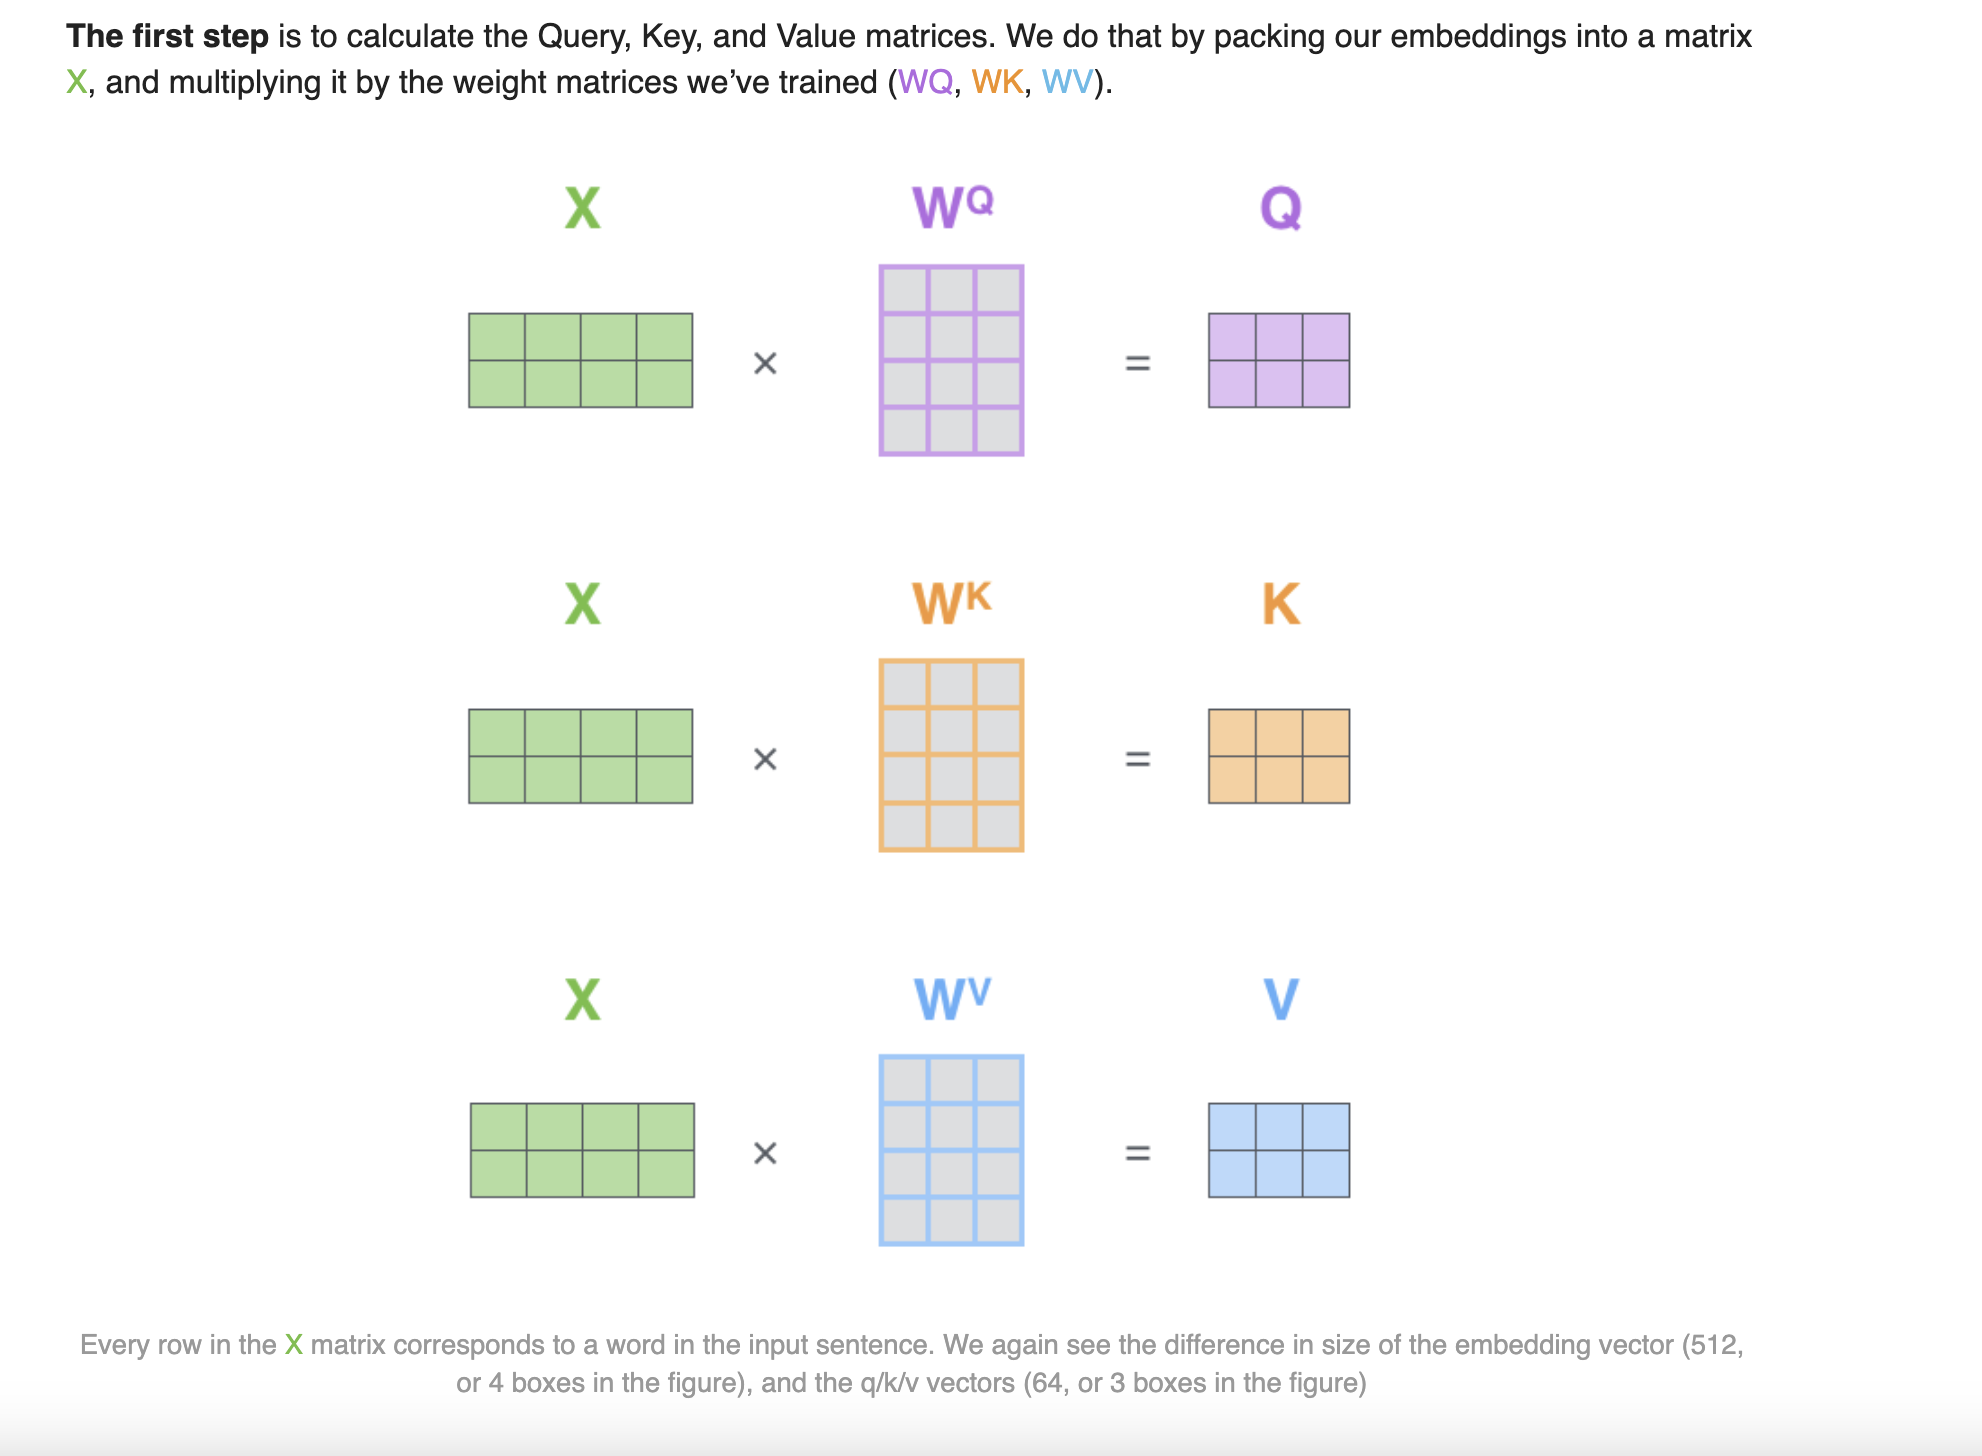
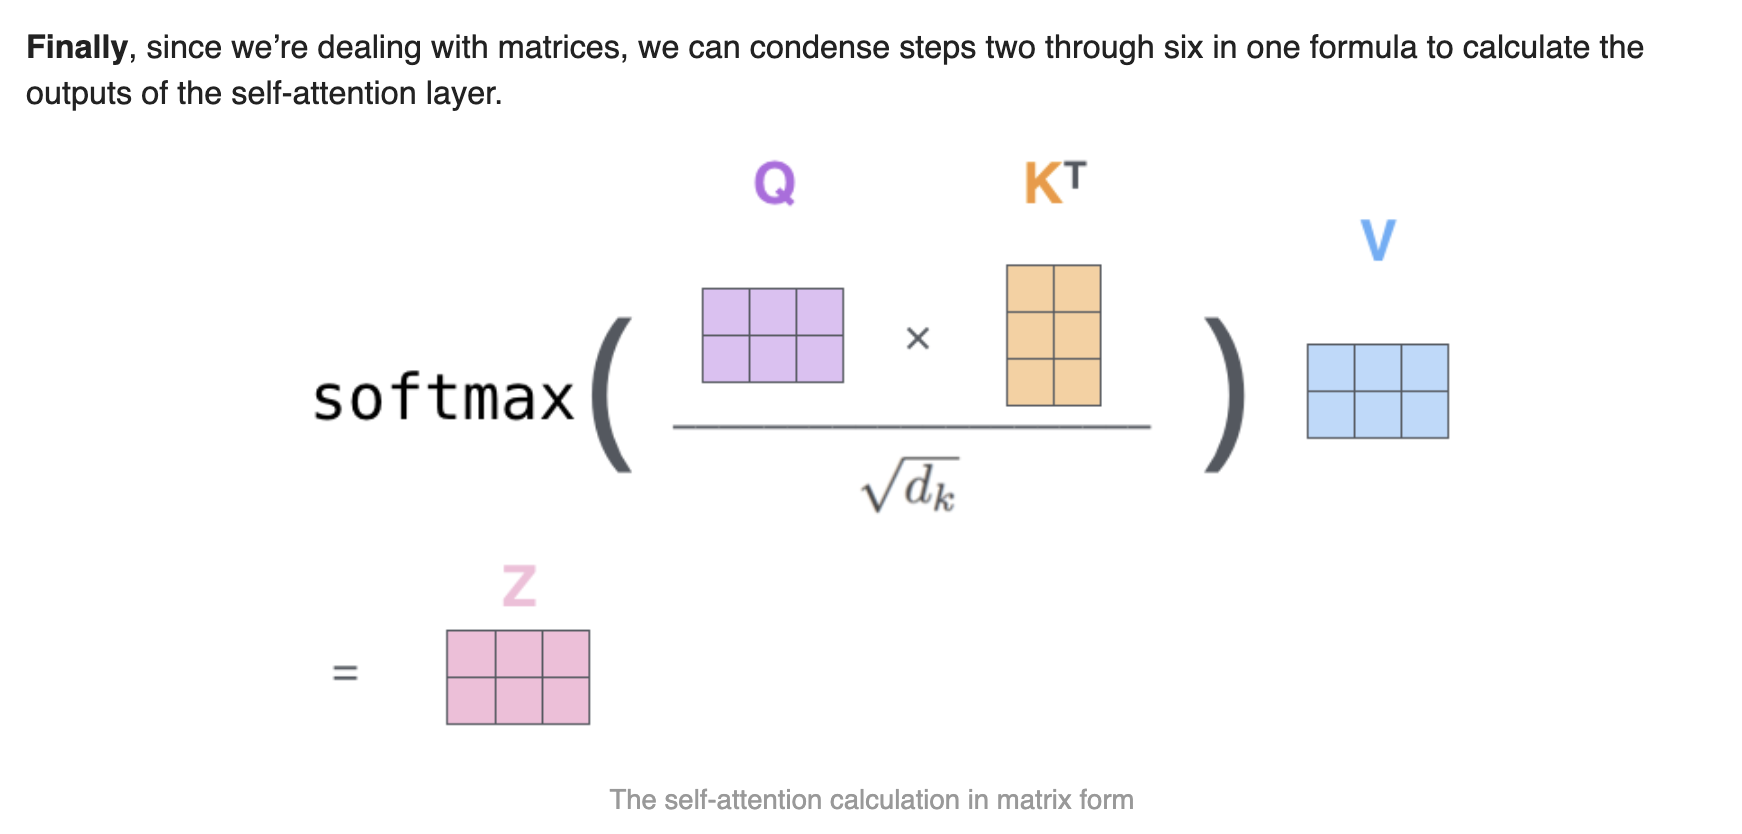

 current token is q, say (4,3,2)  # head_size =2, timestep = 3 <br>
 for batch example i,  Q @ K_T  -> (3, 2) @ (2, 3) -> (3, 3)  <br>
[[k11, k12],      <br> [[k11, k21, k31],    <br>
 [k21, k22],  <br> ->  <br> [k12, k22, k32]]    <br>
 [k31, k32]]  <br>
<br>
[[q11, q12], <br>    [[k11, k21, k31], <br>     
 [q21, q22], <br> @ <br>  [k12, k22, k32]] <br> =  <br>  

 [[q11*k11+q12*k12, q11*k21+q12*k22, q11*k31+q12*k32],     <br>
 [q21*k11+q22*k12, q21*k21+q22*k22, q21*k31+q22*k32],     <br>
  [q31*k11+q32*k12, q31*k21+q32*k22, q31*k31+q32*k32]]      <br>   
  
-mask->  <br>

[[q11*k11+q12*k12,     -inf,        -inf], <br>
 [q21*k11+q22*k12, q21*k21+q22*k22, -inf], <br>
[q31*k11+q32*k12, q31*k21+q32*k22, q31*k31+q32*k32]]  <br>
<br>
### Note: the following is illustration of  softmax(Q @ K.T /scaled) @ Z with an example of looking at future
### query is what we are at, k, v can come from past, future, or encoder (if query is in decoder)
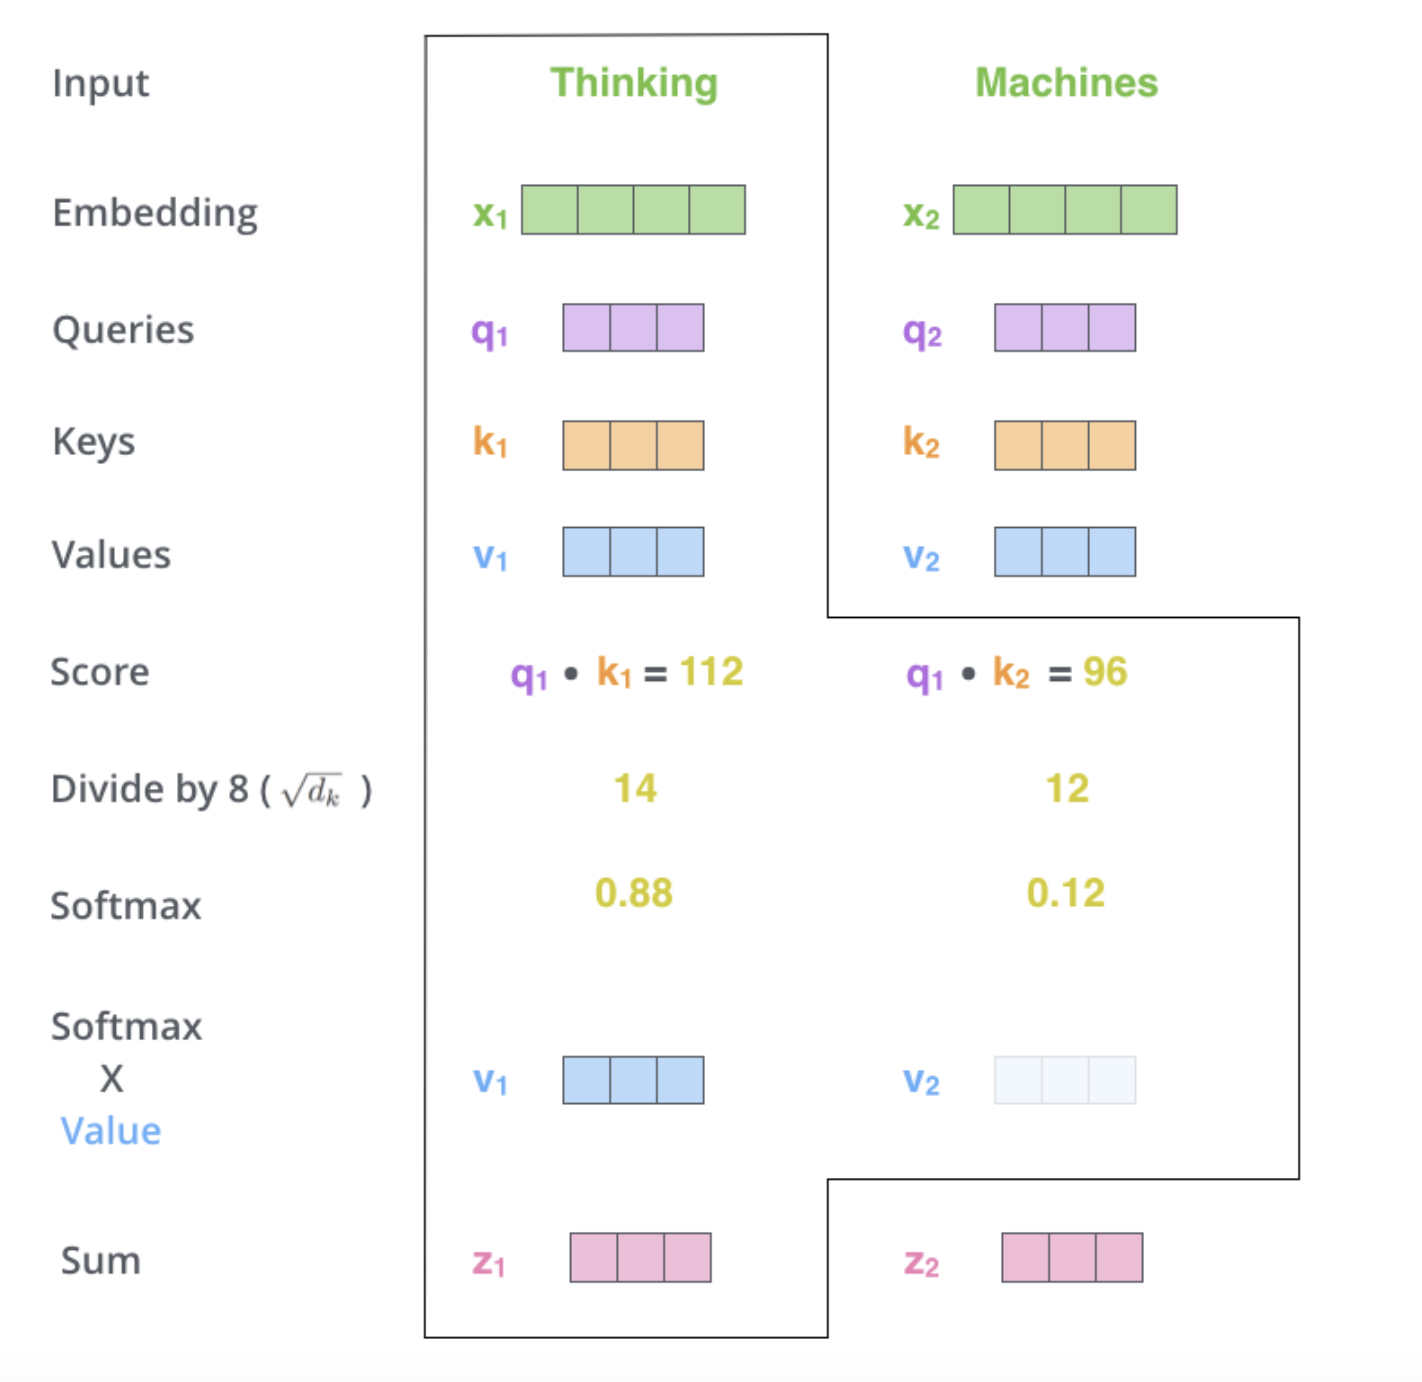

In [245]:
# extract the above to write Head Module
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.head_size = head_size
        self.query = nn.Linear(embed_dim, head_size, bias=False)  # dim of in_features, dim of out_features
        self.key = nn.Linear(embed_dim, head_size, bias=False)
        self.value = nn.Linear(embed_dim, head_size, bias=False)
        # register tril matrix as a buffer, something not need backprop
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) 

    def forward(self, input):
        B, T, C = input.shape    # block_size = T
        q = self.query(input)   # # (B, T, head_size)
        k = self.key(input)
        v = self.value(input)
        
        wei = q @ k.transpose(-2, -1)  
        # (B, T, head_size) -> (B, head_size, T), so q @ k.T is (B, T, head_size) @ (B, head_size, T)=(B, T, T)
        
        #  his code: wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei * (self.head_size ** -0.5)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)  

        wei = F.softmax(wei, dim = -1)

        out = wei @ v # (B, T, T) @ (B, T, head_size) => (B, T, head_size)
        return out


In [256]:
class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        
        self.embedding_table = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding_table = nn.Embedding(block_size, embed_dim)
        self.sa_head = Head(embed_dim)
        self.lm_head = nn.Linear(embed_dim, vocab_size)
    
    def forward(self, input, target=None):  # make target optional
        B, T = input.shape    # examples in the batch: [[47, 64, 43, 52, 10,  0, 14, 43], ....]
        
        tok_embed = self.embedding_table(input)   # -> (B, T, embed_dim)
        
        # make position input by using arange(T)  [0, 1, 2, ...7] for T = 8, then broadcast to (B, T)
        pos_embed = self.position_embedding_table(torch.arange(T, device=device))    # -> (B, T, embed_dim)

        x = tok_embed + pos_embed
        
        x = self.sa_head(x) # a single sa_head  (B, T, head_size=embed_dim)
        logits = self.lm_head(x)   # (B, T, vocab_size) C = vocab_size
        
        if target is None:  
            loss = None    # logits returned will be shape (B, T, C)  
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            target = target.view(B*T)
            loss = F.cross_entropy(logits, target)  # comply with (minibatch,C)
        return logits, loss

    
    def generate(self, input, max_new_tokens):  # more general, allow to condition on more previous chars
        # input is (B, T) array of indices in the current context, where B = 1
        for i in range(max_new_tokens):
            # crop input to block size # most recent tokens within block_size
            input_crop = input[:, -block_size:]

            logits, _ = self(input_crop)
            # print("logits shape: ", logits.shape)  # (B,T,C)
            logits = logits[:, -1, :]   # becomes (B, C)     
            probs = F.softmax(logits, dim=-1)    # (B, C)
            # print("probs shape: ", probs.shape)
            idx_next = torch.multinomial(probs, num_samples=1)
            # print("idx_next shape: ", idx_next.shape)
            input = torch.cat((input, idx_next), dim=1)

        return input

# single head of heads_side 16 : step 4800: train loss 2.3661, val loss 2.4031

In [283]:
n_head = 4

class MultiHeadAttention(nn.Module):
    # several heads of self-attention
    def __init__(self, n_head, head_size):
        super().__init__()
        
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_head)])

    def forward(self, input):
        out = torch.cat([head(input) for head in self.heads], dim=-1)
        return out
        

class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        
        self.embedding_table = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding_table = nn.Embedding(block_size, embed_dim)
       
        self.sa_heads = MultiHeadAttention(n_head, embed_dim//n_head)
        self.lm_head = nn.Linear(embed_dim, vocab_size)
    
    def forward(self, input, target=None):  # make target optional
        B, T = input.shape    # examples in the batch: [[47, 64, 43, 52, 10,  0, 14, 43], ....]
        
        tok_embed = self.embedding_table(input)   # -> (B, T, embed_dim)
        
        # make position input by using arange(T)  [0, 1, 2, ...7] for T = 8, then broadcast to (B, T)
        pos_embed = self.position_embedding_table(torch.arange(T, device=device))    # -> (B, T, embed_dim)

        x = tok_embed + pos_embed
        
        x = self.sa_heads(x) # cat of 4 sa_head of (B, T, head_size/4) -> (B, T, head_size=embed_dim)
        logits = self.lm_head(x)   # (B, T, vocab_size) C = vocab_size
        
        if target is None:  
            loss = None    # logits returned will be shape (B, T, C)  
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            target = target.view(B*T)
            loss = F.cross_entropy(logits, target)  # comply with (minibatch,C)
        return logits, loss

    
    def generate(self, input, max_new_tokens):  # more general, allow to condition on more previous chars
        # input is (B, T) array of indices in the current context, where B = 1
        for i in range(max_new_tokens):
            # crop input to block size # most recent tokens within block_size
            input_crop = input[:, -block_size:]

            logits, _ = self(input_crop)
            # print("logits shape: ", logits.shape)  # (B,T,C)
            logits = logits[:, -1, :]   # becomes (B, C)     
            probs = F.softmax(logits, dim=-1)    # (B, C)
            # print("probs shape: ", probs.shape)
            idx_next = torch.multinomial(probs, num_samples=1)
            # print("idx_next shape: ", idx_next.shape)
            input = torch.cat((input, idx_next), dim=1)

        return input
# step 4800: train loss 2.1383, val loss 2.2359

In [329]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
# Starting with PyTorch 1.12, support for Apple's Metal Performance Shaders (MPS) backend has been introduced, which allows you to utilize the GPU on newer Macs with Apple Silicon (M1, M2, etc.)
print(device)

block_size = 8
batch_size = 32

def get_batch(split):
    data = train_data if split == "train" else val_data
    ix = torch.randint(low=0, high = len(data) - block_size, size=(batch_size,))
    xb = torch.stack([data[startpos: startpos + block_size] for startpos in ix]) 
    # stack takes list of tensors and stack them veritically, along dim=0
    yb = torch.stack([data[startpos+1: startpos + block_size+1] for startpos in ix])
    xb, yb = xb.to(device), yb.to(device)
    return xb, yb

embd_dim = 64
# self-attention use smaller learning rate
learning_rate = 1e-3
max_iters = 5000  # increase interation as lr is smaller

model = GPTLanguageModel(vocab_size)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()   # switch model mode
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):  # pick 200 batches inside train, pick 200 batches inside val
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()  # store 200 losses
        out[split] = losses.mean()
    model.train()   # switch model mode
    return out


for iter in range(max_iters):
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")



mps
step 0: train loss 4.0921, val loss 4.1027
step 300: train loss 2.3440, val loss 2.3705
step 600: train loss 2.1823, val loss 2.2192
step 900: train loss 2.1219, val loss 2.1675
step 1200: train loss 2.0617, val loss 2.1261
step 1500: train loss 2.0224, val loss 2.1073
step 1800: train loss 1.9891, val loss 2.0754
step 2100: train loss 1.9656, val loss 2.0577
step 2400: train loss 1.9372, val loss 2.0588
step 2700: train loss 1.9479, val loss 2.0586
step 3000: train loss 1.9168, val loss 2.0378
step 3300: train loss 1.8898, val loss 2.0150
step 3600: train loss 1.8893, val loss 2.0107
step 3900: train loss 1.8866, val loss 2.0062
step 4200: train loss 1.8604, val loss 1.9969
step 4500: train loss 1.8591, val loss 1.9895
step 4800: train loss 1.8568, val loss 1.9727


In [290]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embd_dim, embd_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        
        self.embedding_table = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding_table = nn.Embedding(block_size, embed_dim)
       
        self.sa_heads = MultiHeadAttention(n_head, embed_dim//n_head)
        self.ffwd = FeedFoward(embed_dim)
        self.lm_head = nn.Linear(embed_dim, vocab_size)
    
    def forward(self, input, target=None):  # make target optional
        B, T = input.shape    # examples in the batch: [[47, 64, 43, 52, 10,  0, 14, 43], ....]
        
        tok_embed = self.embedding_table(input)   # -> (B, T, embed_dim)
        
        # make position input by using arange(T)  [0, 1, 2, ...7] for T = 8, then broadcast to (B, T)
        pos_embed = self.position_embedding_table(torch.arange(T, device=device))    # -> (B, T, embed_dim)

        x = tok_embed + pos_embed
        
        x = self.sa_heads(x) # cat of 4 sa_head of (B, T, head_size/4) -> (B, T, head_size=embed_dim)

        # here we add ffwd, allow each token to "think" independently after the previous layer 
        x = self.ffwd(x)
        logits = self.lm_head(x)   # (B, T, vocab_size) C = vocab_size
        
        if target is None:  
            loss = None    # logits returned will be shape (B, T, C)  
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            target = target.view(B*T)
            loss = F.cross_entropy(logits, target)  # comply with (minibatch,C)
        return logits, loss

    
    def generate(self, input, max_new_tokens):  # more general, allow to condition on more previous chars
        # input is (B, T) array of indices in the current context, where B = 1
        for i in range(max_new_tokens):
            # crop input to block size # most recent tokens within block_size
            input_crop = input[:, -block_size:]

            logits, _ = self(input_crop)
            # print("logits shape: ", logits.shape)  # (B,T,C)
            logits = logits[:, -1, :]   # becomes (B, C)     
            probs = F.softmax(logits, dim=-1)    # (B, C)
            # print("probs shape: ", probs.shape)
            idx_next = torch.multinomial(probs, num_samples=1)
            # print("idx_next shape: ", idx_next.shape)
            input = torch.cat((input, idx_next), dim=1)

        return input

# with ffwd, step 4800: train loss 1.9774, val loss 2.0997

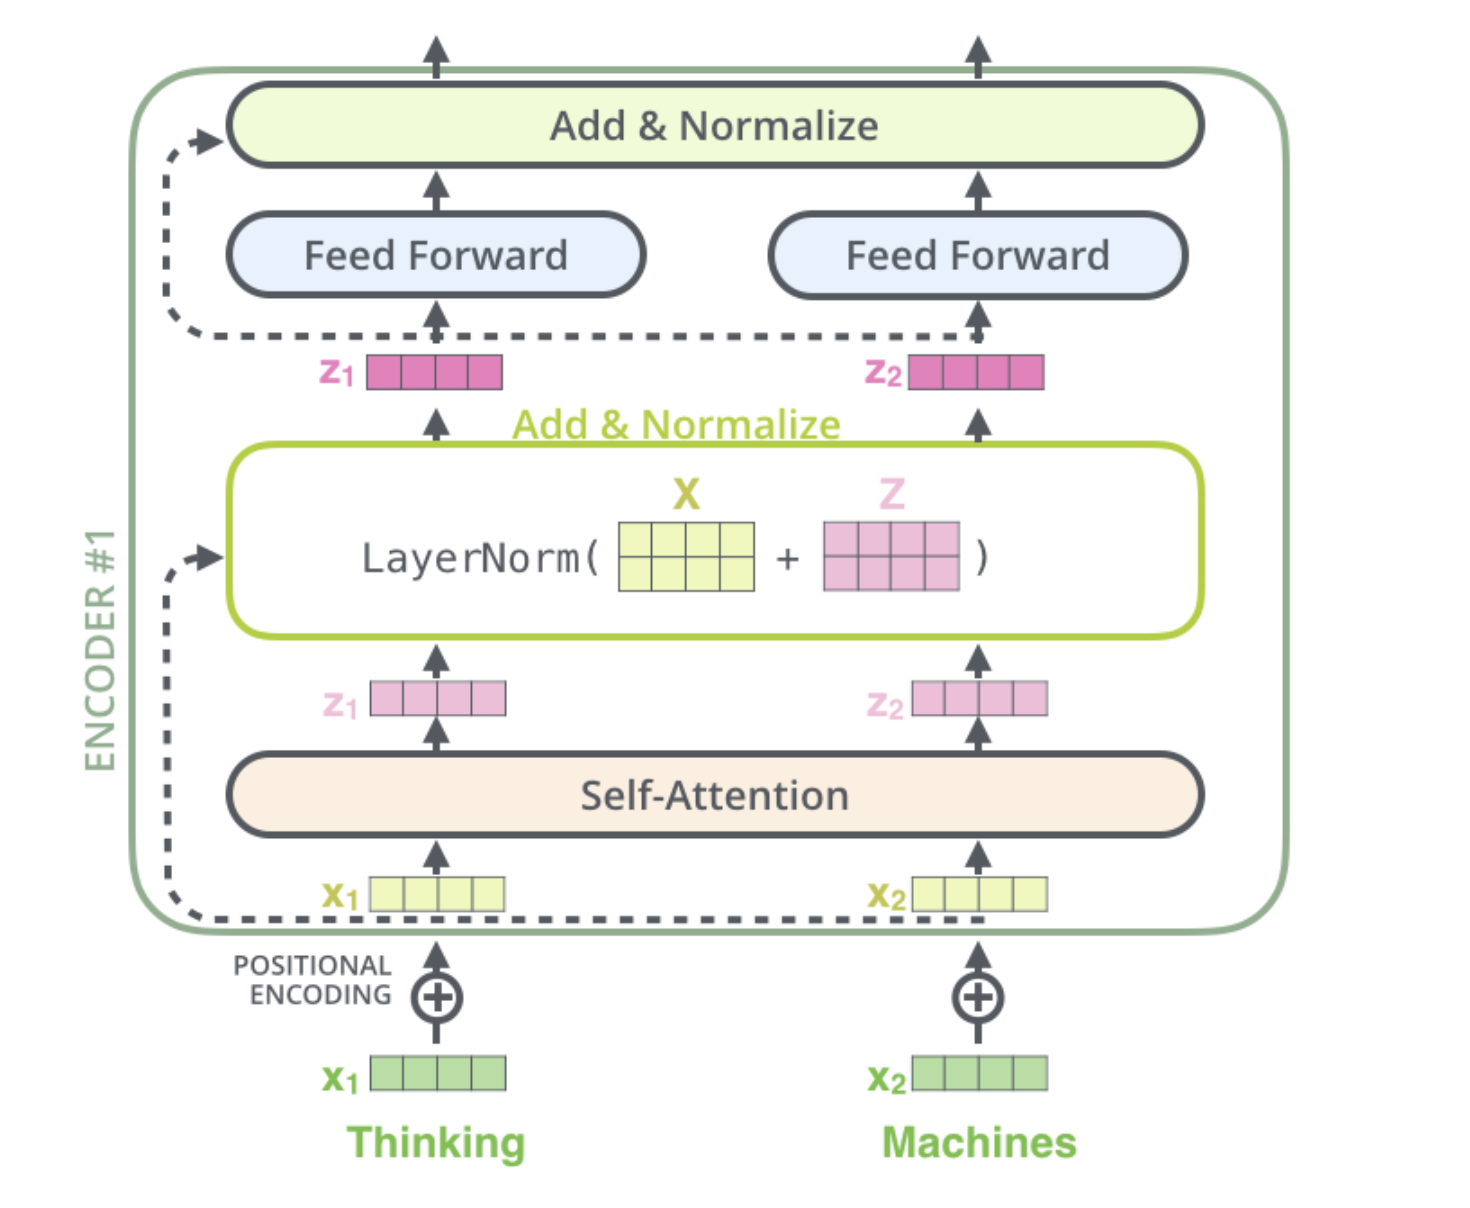

### now wrap sa_heads and ffwd into a block, and repelicate blocks,
### but this will become deep, so we need to add some optimization methods
- 1. resudual connections:  addition distribute grads equally to both their branches.<br>
  Originally, we have this weighted sum of V matrix concatenated 4 times. <br> 
  
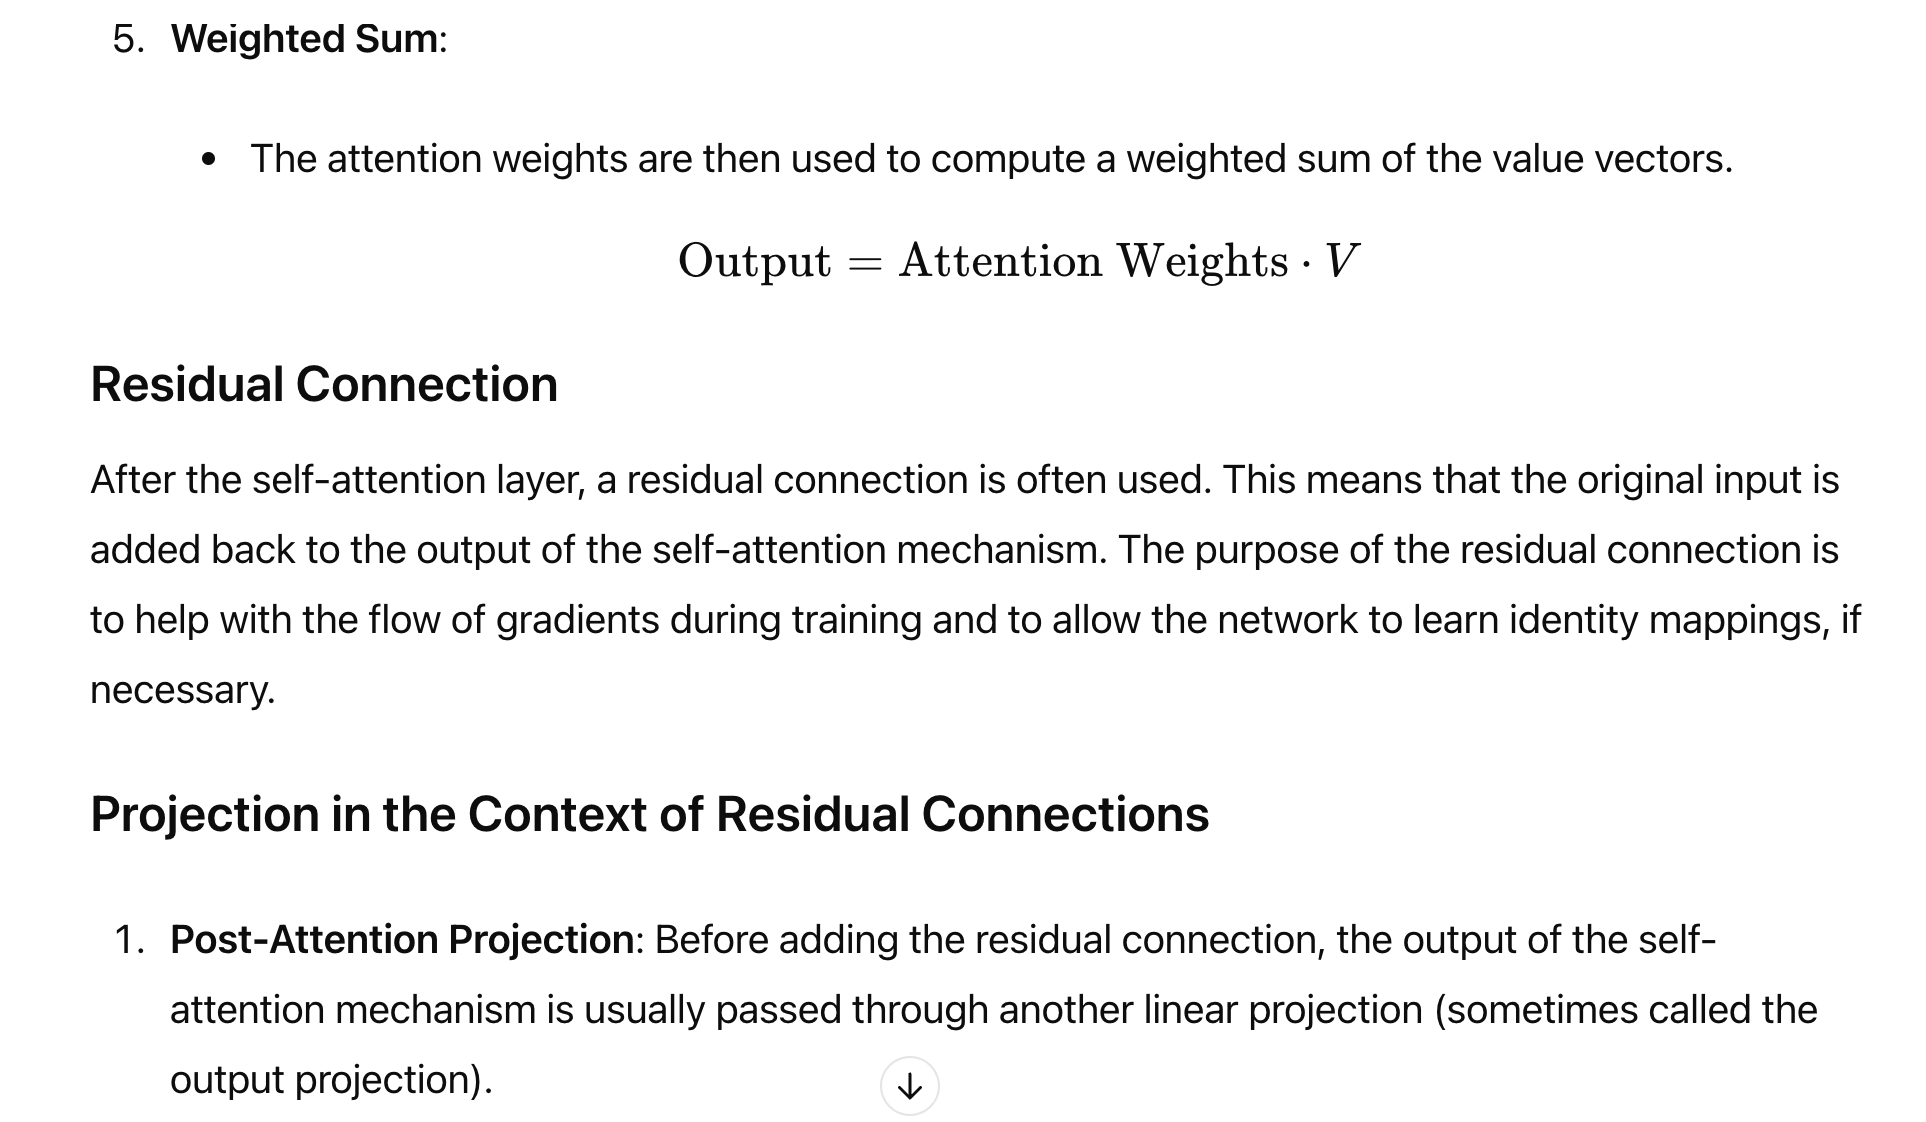
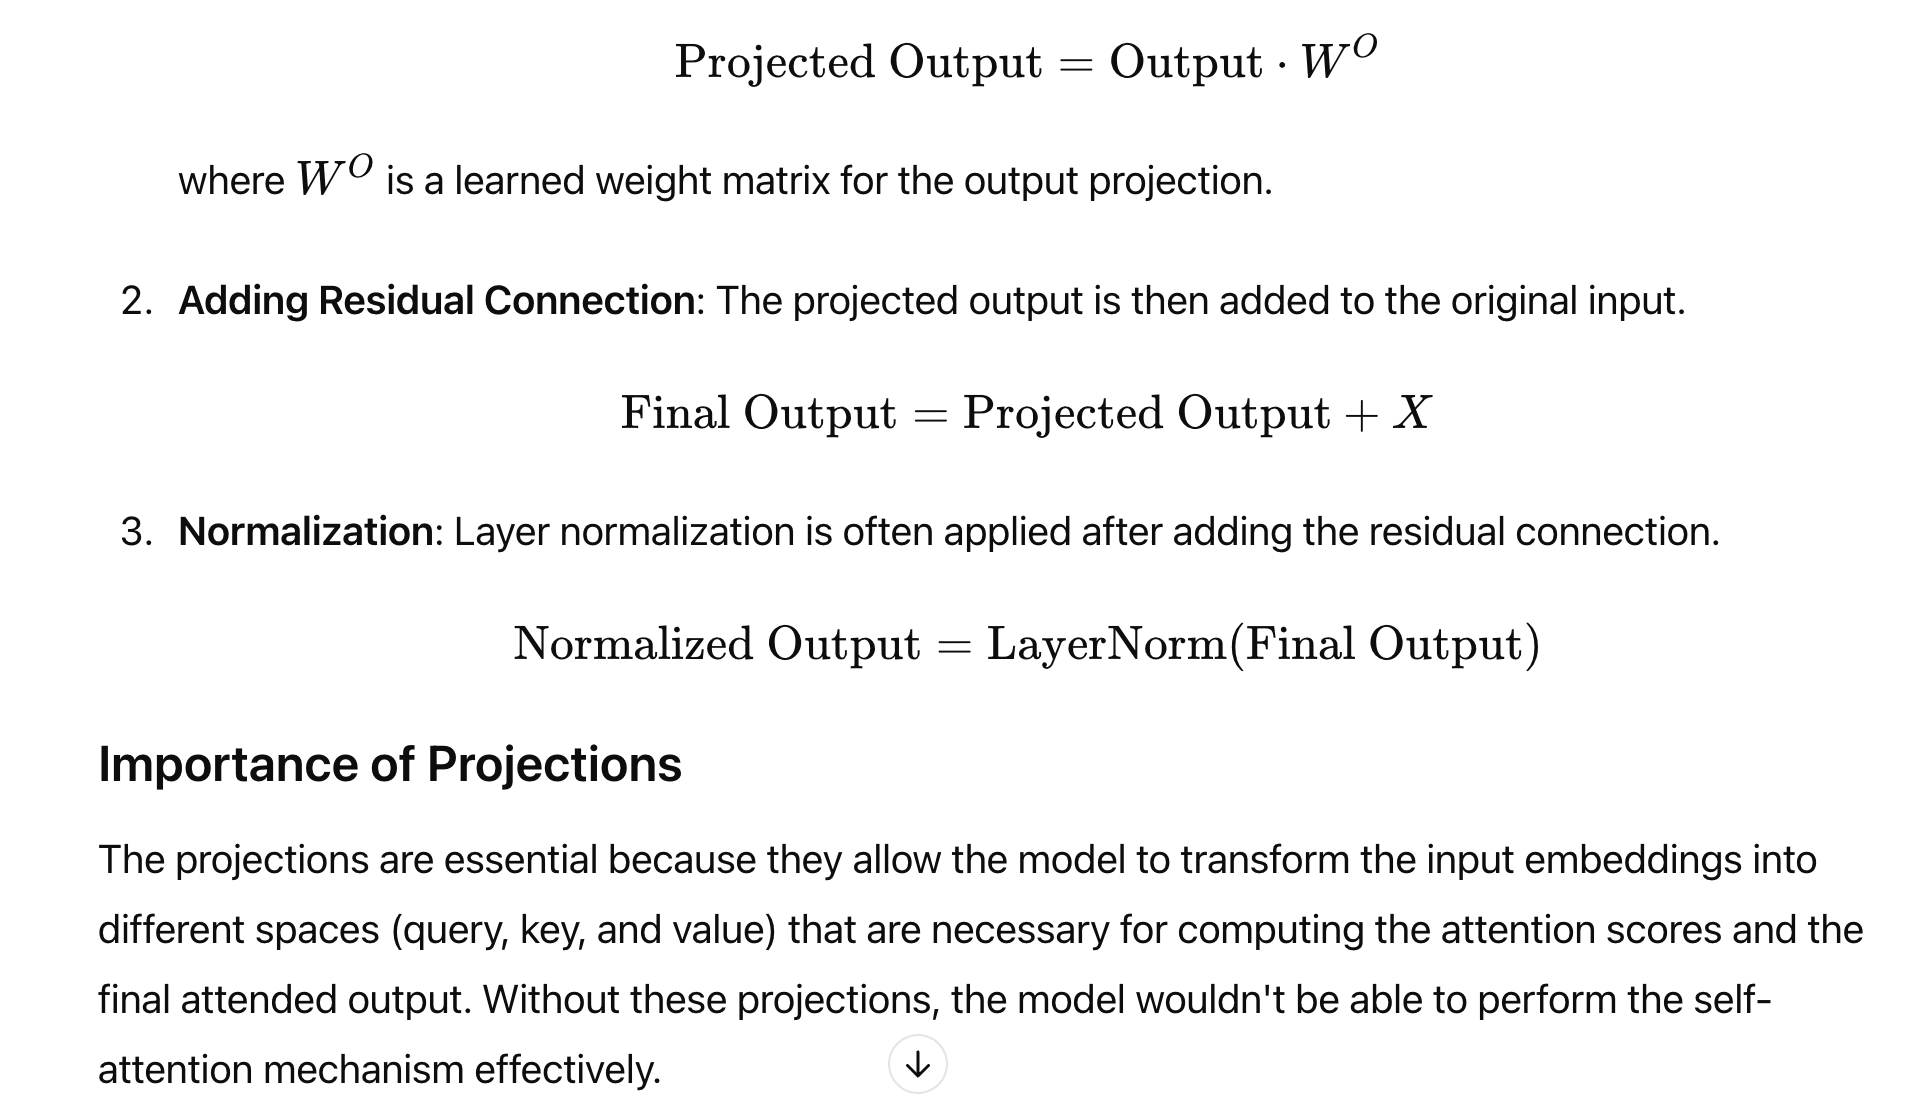

In [302]:
n_head = 4
n_layer = 4
embed_dim= 64

# add residual connection steps for multihead
class MultiHeadAttention(nn.Module):
    # several heads of self-attention
    def __init__(self, n_head, head_size):
        super().__init__()
        
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_head)])
        # projection is simply a linear layer
        self.proj = nn.Linear(head_size * n_head, embd_dim)  # head_size * num_heads = embed_dim

    def forward(self, input):
        # nn.ModuleList just stores a list nn.Modules and it does not have a forward() method. So you can not call it like a normal module.
        # here we call head(input) which is the single head module
        out = torch.cat([head(input) for head in self.heads], dim=-1)   # this is original Output = Attention Weights @ V  inside each head
        # apply a linear layer on out, this is the step 1.
        out = self.proj(out)
        
        return out

# similar residual for feedforward, so we need another linear layer for out, in paper, 
class FeedFoward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        # nn.Sequential as a module and you can call it with a input like the normal module.
        self.net = nn.Sequential(
            # nn.Linear(embd_dim, n_embd),
            nn.Linear(embd_dim, 4 * embd_dim),
            nn.ReLU(),
            nn.Linear(4 * embd_dim, embd_dim),   # this is the projection, according to the paper, the inner layer dim is 4 * embed_dim
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, embd_dim, n_head):
        # embd_dim: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = embd_dim // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(embd_dim)

    def forward(self, x):
        # # core operations:
        # x = self.sa(x)
        # x = self.ffwd(x)
        
        # add residual connection steps 
        x = x + self.sa(x)   # for multihead, this the above step 2.
        x = x + self.ffwd(x)  
        return x


class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        
        self.embedding_table = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding_table = nn.Embedding(block_size, embed_dim)
        
        # n PyTorch, the asterisk (*) before a list of layers in nn.Sequential unpacks the list so that each element is passed as a separate 
        # argument. For example, nn.Sequential(*[Block(embd_dim, n_head=n_head) for _ in range(n_layer)]) creates a sequential container 
        # where each Block is a separate argument to nn.Sequential. Without the asterisk, the list itself would be passed as a single 
        # argument, leading to an error. This unpacking allows you to dynamically generate a sequence of layers and pass them correctly.
        self.blocks = nn.Sequential(*[Block(embd_dim, n_head=n_head) for _ in range(n_layer)])
        
        self.lm_head = nn.Linear(embed_dim, vocab_size)
    
    def forward(self, input, target=None):  # make target optional
        B, T = input.shape    # examples in the batch: [[47, 64, 43, 52, 10,  0, 14, 43], ....]
        
        tok_embed = self.embedding_table(input)   # -> (B, T, embed_dim)
        
        # make position input by using arange(T)  [0, 1, 2, ...7] for T = 8, then broadcast to (B, T)
        pos_embed = self.position_embedding_table(torch.arange(T, device=device))    # -> (B, T, embed_dim)

        x = tok_embed + pos_embed
        
        # here we go through blocks
        x = self.blocks(x)   # (B,T,C)
        
        logits = self.lm_head(x)   # (B, T, vocab_size) C = vocab_size
        
        if target is None:  
            loss = None    # logits returned will be shape (B, T, C)  
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            target = target.view(B*T)
            loss = F.cross_entropy(logits, target)  # comply with (minibatch,C)
        return logits, loss

    
    def generate(self, input, max_new_tokens):  # more general, allow to condition on more previous chars
        # input is (B, T) array of indices in the current context, where B = 1
        for i in range(max_new_tokens):
            # crop input to block size # most recent tokens within block_size
            input_crop = input[:, -block_size:]

            logits, _ = self(input_crop)
            # print("logits shape: ", logits.shape)  # (B,T,C)
            logits = logits[:, -1, :]   # becomes (B, C)     
            probs = F.softmax(logits, dim=-1)    # (B, C)
            # print("probs shape: ", probs.shape)
            idx_next = torch.multinomial(probs, num_samples=1)
            # print("idx_next shape: ", idx_next.shape)
            input = torch.cat((input, idx_next), dim=1)

        return input

# go back to cell 301 and train
# step 4800: train loss 1.8430, val loss 1.9827

In [303]:
# try generate again
out = model.generate(input=torch.tensor([0]).view(1,1).to(device), max_new_tokens=300)  # torch.tensor is built-in, not a Tensor
# out = model.generate(input=torch.LongTensor([0]).view(1,1).to(device), max_new_tokens=300)
print(decode(out[0].tolist()))
# much more english looking words!


Foast.

MERCUTIO:
Provose
O upon
in him.

HENRY OI well be all the goently the deven fear reathy scariant in marry way art ome
burne. Pinsus beath, dlehice:

Bid twoes neaks is of sulbust tlant's should. To goodly our bloods are mother it.
Lance to ploge your fatherselfn you conter to could 'thurein


### Optimization 2: Layer Norm <br>
 - Rather than Batch norm, take mean across batch, this time normalize with single examples, dim = -1, last dimension

In [321]:

# running mean and var no longer needed
class LayerNorm1d:
  
    def __init__(self, embd_dim, eps=1e-5):
        # these will be initialized at first, same set of them shared and updated when __call__ is called for diff x
        self.eps = eps
        self.gain = torch.ones((1, embd_dim))
        self.bias = torch.zeros((1, embd_dim))
      
    def __call__(self, x): # x shape [batch_size, hidden_dim (= fan_out of previous layer); x is the hidden neurons resulted from a layer where matrix multiplications take place, e.g. linear layer
        # x: [B, T, emb_dim]
        xmean = x.mean(-1, keepdim=True) # normalize across feature dimension: embd_dim
        xvar = x.var(-1, unbiased=False, keepdim=True)
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        out = self.gain * xhat + self.bias

        return out
    
    def parameters(self):
        return [self.bngain, self.bnbias]

In [327]:
# Test: # check self-written layernorm
batch, sentence_length, embd_dim = 2, 5, 3
embedding = torch.randn(batch, sentence_length, embd_dim)

layer_norm = nn.LayerNorm(embd_dim)
ln2 = LayerNorm1d(embd_dim)
# Activate module
out = layer_norm(embedding)
out2 = ln2(embedding)
print(out2.shape)
torch.allclose(out, out2)

torch.Size([2, 5, 3])


True

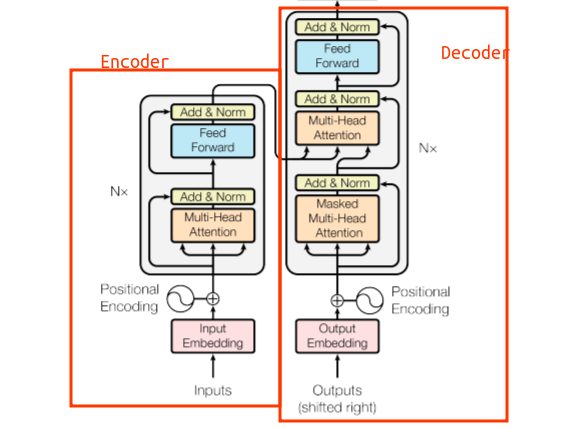!
<br>
- Encoder on the left; decoder on the right <br>
- Some Modification to original architecture: <br>
- we do not have the middle part (which refering from the encoder) inside the decoder <br>
- apply laynorm BEFORE attention, and feed-forward, instead of AFTER <br>
so the correct order is layernorm -> multiheadAttention -> layernorm -> feed forward

In [328]:
n_head = 4
n_layer = 4
embed_dim= 64

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, embd_dim, n_head):
        # embd_dim: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = embd_dim // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(embd_dim)
        
        self.ln1 = nn.LayerNorm(embd_dim)
        self.ln2 = nn.LayerNorm(embd_dim)

    def forward(self, x):
        
        # add layernorm before each 
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        
        return x


class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        
        self.embedding_table = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding_table = nn.Embedding(block_size, embed_dim)

        #self.blocks = nn.Sequential(*[Block(embd_dim, n_head=n_head) for _ in range(n_layer)])
        self.blocks = nn.Sequential(
            Block(embd_dim, n_head=4),
            Block(embd_dim, n_head=4),
            Block(embd_dim, n_head=4),
            # add a layernorm before final linear layer
            nn.LayerNorm(embd_dim),
        )
        # final linear layer that output logits
        self.lm_head = nn.Linear(embed_dim, vocab_size)

    
    def forward(self, input, target=None):  # make target optional
        B, T = input.shape    # examples in the batch: [[47, 64, 43, 52, 10,  0, 14, 43], ....]
        
        tok_embed = self.embedding_table(input)   # -> (B, T, embed_dim)
        
        # make position input by using arange(T)  [0, 1, 2, ...7] for T = 8, then broadcast to (B, T)
        pos_embed = self.position_embedding_table(torch.arange(T, device=device))    # -> (B, T, embed_dim)

        x = tok_embed + pos_embed
        
        # here we go through blocks
        x = self.blocks(x)   # (B,T,C)
        
        logits = self.lm_head(x)   # (B, T, vocab_size) C = vocab_size
        
        if target is None:  
            loss = None    # logits returned will be shape (B, T, C)  
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            target = target.view(B*T)
            loss = F.cross_entropy(logits, target)  # comply with (minibatch,C)
        return logits, loss

    
    def generate(self, input, max_new_tokens):  # more general, allow to condition on more previous chars
        # input is (B, T) array of indices in the current context, where B = 1
        for i in range(max_new_tokens):
            # crop input to block size # most recent tokens within block_size
            input_crop = input[:, -block_size:]

            logits, _ = self(input_crop)
            # print("logits shape: ", logits.shape)  # (B,T,C)
            logits = logits[:, -1, :]   # becomes (B, C)     
            probs = F.softmax(logits, dim=-1)    # (B, C)
            # print("probs shape: ", probs.shape)
            idx_next = torch.multinomial(probs, num_samples=1)
            # print("idx_next shape: ", idx_next.shape)
            input = torch.cat((input, idx_next), dim=1)

        return input

# step 4800: train loss 1.8568, val loss 1.9727

## optimization 3:
- dropout: regularization, prevent overfitting when scale up model
- anywhere we have residual connections and inside attention

In [335]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
# ------------

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.head_size = head_size
        self.query = nn.Linear(embed_dim, head_size, bias=False)  # dim of in_features, dim of out_features
        self.key = nn.Linear(embed_dim, head_size, bias=False)
        self.value = nn.Linear(embed_dim, head_size, bias=False)
        # register tril matrix as a buffer, something not need backprop
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        # add dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        B, T, C = input.shape    # block_size = T
        q = self.query(input)   # # (B, T, head_size)
        k = self.key(input)
        v = self.value(input)
        
        wei = q @ k.transpose(-2, -1)  
        # (B, T, head_size) -> (B, head_size, T), so q @ k.T is (B, T, head_size) @ (B, head_size, T)=(B, T, T)
        
        #  his code: wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei * (self.head_size ** -0.5)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)  

        wei = F.softmax(wei, dim = -1)
        
        # add dropout
        wei = self.dropout(wei)
        
        out = wei @ v # (B, T, T) @ (B, T, head_size) => (B, T, head_size)
        return out

class MultiHeadAttention(nn.Module):
    # several heads of self-attention
    def __init__(self, n_head, head_size):
        super().__init__()
        
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_head)])
        # projection is simply a linear layer
        self.proj = nn.Linear(head_size * n_head, embd_dim)  # head_size * num_heads = embed_dim

        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        # nn.ModuleList just stores a list nn.Modules and it does not have a forward() method. So you can not call it like a normal module.
        # here we call head(input) which is the single head module
        out = torch.cat([head(input) for head in self.heads], dim=-1)   # this is original Output = Attention Weights @ V  inside each head
        # apply a linear layer on out, this is the step 1.
        # out = self.proj(out)

        # add dropout
        out = self.dropout(self.proj(out))
        
        return out

# similar residual for feedforward, so we need another linear layer for out, in paper, 
class FeedFoward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        # nn.Sequential as a module and you can call it with a input like the normal module.
        self.net = nn.Sequential(
            # nn.Linear(embd_dim, n_embd),
            nn.Linear(embd_dim, 4 * embd_dim),
            nn.ReLU(),
            nn.Linear(4 * embd_dim, embd_dim),   # this is the projection, according to the paper, the inner layer dim is 4 * embed_dim
            # may also add dropout here inside feedforward
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, embd_dim, n_head):
        # embd_dim: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = embd_dim // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(embd_dim)
        
        self.ln1 = nn.LayerNorm(embd_dim)
        self.ln2 = nn.LayerNorm(embd_dim)

    def forward(self, x):
        
        # add layernorm before each 
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        
        return x


class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        
        self.embedding_table = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding_table = nn.Embedding(block_size, embed_dim)

        #self.blocks = nn.Sequential(*[Block(embd_dim, n_head=n_head) for _ in range(n_layer)])
        self.blocks = nn.Sequential(
            Block(embd_dim, n_head=4),
            Block(embd_dim, n_head=4),
            Block(embd_dim, n_head=4),
            # add a layernorm before final linear layer
            nn.LayerNorm(embd_dim),
        )
        # final linear layer that output logits
        self.lm_head = nn.Linear(embed_dim, vocab_size)

    
    def forward(self, input, target=None):  # make target optional
        B, T = input.shape    # examples in the batch: [[47, 64, 43, 52, 10,  0, 14, 43], ....]
        
        tok_embed = self.embedding_table(input)   # -> (B, T, embed_dim)
        
        # make position input by using arange(T)  [0, 1, 2, ...7] for T = 8, then broadcast to (B, T)
        pos_embed = self.position_embedding_table(torch.arange(T, device=device))    # -> (B, T, embed_dim)

        x = tok_embed + pos_embed
        
        # here we go through blocks
        x = self.blocks(x)   # (B,T,C)
        
        logits = self.lm_head(x)   # (B, T, vocab_size) C = vocab_size
        
        if target is None:  
            loss = None    # logits returned will be shape (B, T, C)  
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            target = target.view(B*T)
            loss = F.cross_entropy(logits, target)  # comply with (minibatch,C)
        return logits, loss

    
    def generate(self, input, max_new_tokens):  # more general, allow to condition on more previous chars
        # input is (B, T) array of indices in the current context, where B = 1
        for i in range(max_new_tokens):
            # crop input to block size # most recent tokens within block_size
            input_crop = input[:, -block_size:]

            logits, _ = self(input_crop)
            # print("logits shape: ", logits.shape)  # (B,T,C)
            logits = logits[:, -1, :]   # becomes (B, C)     
            probs = F.softmax(logits, dim=-1)    # (B, C)
            # print("probs shape: ", probs.shape)
            idx_next = torch.multinomial(probs, num_samples=1)
            # print("idx_next shape: ", idx_next.shape)
            input = torch.cat((input, idx_next), dim=1)

        return input

mps
